In [2]:
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt
import csv
from sklearn.model_selection import StratifiedShuffleSplit as SSS
%matplotlib inline

random_state = 1234

# Loading datasets:

In [3]:
iris = datasets.load_iris()
sss = SSS(1, test_size = 30, random_state = random_state)
[(train_idx, test_idx)] = list(sss.split(iris['data'], iris['target']))

In [4]:
iris_train = {
    'y': iris['target'][train_idx],
    'x': iris['data'][train_idx]
}
iris_test = {
    'y': iris['target'][test_idx],
    'x': iris['data'][test_idx]
}

In [5]:
def load_dna(file, numdata, numfeatures=180):
    dna = {
        'y': np.zeros(numdata),
        'x': np.zeros((numdata, numfeatures))
    }

    with open(file, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter = '\n')
        i = 0
        for row in reader:
            rowstr = row[0]
            splitrow = rowstr.split()
            dna['y'][i] = int(splitrow[0]) - 1
            
            for entry in splitrow[1:]:
                [idx, val] = entry.split(':')
                dna['x'][i][int(idx)-1] = int(val)
                
            i += 1
    return(dna)
dna_train = load_dna('dna.scale.tr', 1400)
dna_test = load_dna('dna.scale.t', 1186)

# Task 1: One Vs. All SVM

$$\mathscr{L}(\mathbf{w}) = \frac{1}{2}\mathbf{w}^T\mathbf{w} + \lambda \sum_{i}  max\left(0, \ 1-y_i\mathbf{w}^{T}\mathbf{x}_{i}\right) $$

$$ \frac{\partial \mathscr{L}}{\partial \mathbf{w}} = \mathbf{w} + \lambda \sum_{i} \begin{cases} 0 ,& y_i\mathbf{w}^{T}\mathbf{x}_{i} \geq 1 \\ -y_{i}\mathbf{x}_{i},& else\end{cases}$$

In [22]:
class OneVAllSVM(object):
    def __init__(self, random_seed = None):
        self.random = np.random.RandomState(random_seed)
        
        L = lambda w, x, y, lamb: .5*np.dot(w,w) + lamb * sum([max(0, 1-y[i]*np.dot(w, x[i])) for i in range(len(y))])
        self.L = L
        
        dLdw = lambda w, x, y, lamb: w + lamb * np.sum(
                [np.zeros(len(x[i])) if y[i]*np.dot(w, x[i]) >= 1 
                else -y[i]*x[i] for i in range(len(y))],
                axis = 0
            )
        self.dLdw = dLdw
        
    def train(self, x, y, lamb, lr, iters):
        n_samples = x.shape[0]
        n_features = x.shape[1]
        n_classes = len(np.unique(y))
        
        
        #Add bias column
        xw1 = np.hstack((np.ones((n_samples, 1)), x))
        
        #"Xavier" initialization
        W = self.random.normal(0, np.sqrt(2/(n_features+1)), 
                             (n_classes,n_features+1))
        self.W = W
        
        accs = []
        losses = np.zeros((iters, n_classes))
        for iteration in range(iters):
            for i in range(n_classes):
                #convert to one versus all labeling
                class_i = np.unique(y)[i]
                y_1va = np.array([1 if yi == class_i else -1 for yi in y])
                W[i,:] = W[i,:] - lr*self.dLdw(W[i,:], xw1, y_1va, lamb)
                accs.append(self.accuracy(x, y))
                losses[iteration, i] = self.L(W[i,:], xw1, y_1va, lamb)
    
    def predict(self, x):
        x_bias = np.hstack((np.ones((x.shape[0], 1)), x))
        return(
            np.array(
                [
                    [np.dot(self.W[i], x_bias[j]) for i in range(self.W.shape[0])]
                    for j in range(len(x_bias))
                ]
            )
        )
    def predict_labels(self, x):
        return(np.argmax(self.predict(x), 1))
    
    def accuracy(self, x, y):
        return(sum(self.predict_labels(x) == y)/float(len(y)))

Lambda = 0.500000 
Train accuracy: 0.675000 
Test accuracy: 0.666667

[[ 0.34969189 -0.44235808  1.13602972 -0.39984552 -0.55801961]
 [ 0.47187232  0.22991315 -0.89746104  0.40245281 -1.16207394]
 [ 0.35519015 -0.15396349 -0.45522474  0.27834456  0.63995452]]
Lambda = 2.000000 
Train accuracy: 0.891667 
Test accuracy: 0.900000

[[ 0.0336899   0.02983999  0.64977276 -0.4300068  -1.38449929]
 [ 0.05576037  0.0651069  -0.40300874  0.0138166  -0.02910909]
 [-0.70585715 -0.54611528 -1.41237342  1.11528487  1.69666094]]
Lambda = 5.000000 
Train accuracy: 0.900000 
Test accuracy: 0.833333

[[-0.19938981 -0.08911425  1.05410579 -0.91754796 -0.20797522]
 [ 0.46981893  0.5537621  -1.30002649 -0.1741807  -0.17677355]
 [-0.77082106 -1.27294192 -1.01936657  1.68702267  2.13660015]]
Lambda = 10.000000 
Train accuracy: 0.966667 
Test accuracy: 0.900000

[[-0.39775932  0.11151599  0.77977885 -0.85790296 -0.47273493]
 [ 1.53448717  0.82706478 -2.11310006  0.47630844 -1.51121176]
 [-1.2550279  -1.760496

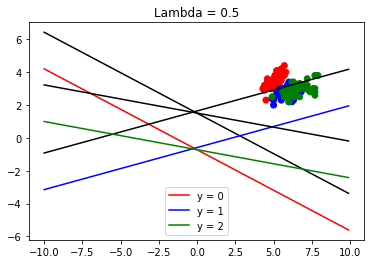

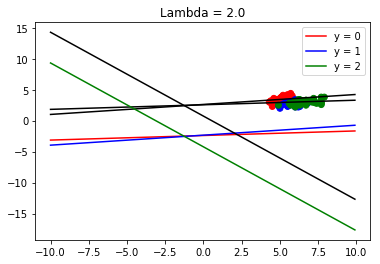

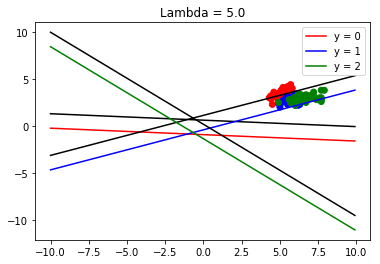

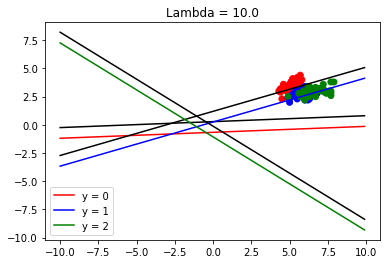

In [28]:
x = iris['data']
y = iris['target']
svm = OneVAllSVM(random_state)

for lamb in [.5, 2, 5, 10]:
    svm.train(iris_train['x'], iris_train['y'], lamb = lamb, lr = .0001, iters = 500)


    W = svm.W 
    plt.figure()
    plt.title("Lambda = %.1f" %(lamb))
    plotrange = np.arange(-10,10,.1)
    plt.plot(plotrange, ((1-W[0,0])-W[0,1]*plotrange)/W[1,2], color = 'r', label = 'y = 0')
    plt.plot(plotrange, ((-1-W[0,0])-W[0,1]*plotrange)/W[1,2], color = 'black')

    plt.plot(plotrange, ((1-W[1,0])-W[1,1]*plotrange)/W[1,2], color = 'b', label = 'y = 1')
    plt.plot(plotrange, ((-1-W[1,0])-W[1,1]*plotrange)/W[1,2], color = 'black')

    plt.plot(plotrange, ((1-W[2,0])-W[2,1]*plotrange)/W[1,2], color = 'g', label = 'y = 2')
    plt.plot(plotrange, ((-1-W[2,0])-W[2,1]*plotrange)/W[1,2], color = 'black')

    plt.scatter(x[:,0], x[:,1], color = np.array(['r' if yi ==0 else 'b' if yi ==1 else 'g' for yi in y]))
    plt.legend()
    print("Lambda = %f \nTrain accuracy: %f \nTest accuracy: %f\n" 
          %(
              lamb, 
              svm.accuracy(iris_train['x'], iris_train['y']), 
              svm.accuracy(iris_test['x'], iris_test['y'])
           )
         )
    print(W)

# Task 2: Explicit Multi-class SVM

$$\mathscr{L}(\mathbf{w}_1,\ldots,\mathbf{w}_K) = \frac{1}{2}\sum_{k = 1}^K \mathbf{w}_k^T\mathbf{w}_k + \lambda \sum_{i}\sum_{k=1,k \neq y_i}  max\left(0, \ 1-\left(\mathbf{w}_{y_i}^T \mathbf{x}_i - \mathbf{w}_k^{T}\mathbf{x}_{i}\right)\right) $$

$$ 
\frac{\partial \mathscr{L}}{\partial \mathbf{w}_k} =
\mathbf{w}_k + \lambda \sum_{i} 
\begin{cases}
-\mathbf{x}_i\sum_{j \neq k}\mathbf{1}\left(\mathbf{w}_{y_i}\mathbf{x}_i-\mathbf{w}_{j}\mathbf{x}_i<1\right),& k = y_i \\
\mathbf{x}_i \mathbf{1}\left(\mathbf{w}_{y_i}\mathbf{x}_i-\mathbf{w}_{k}\mathbf{x}_i<1\right),& k \neq y_i
\end{cases}
$$

In [15]:
class MCSVM(object):
    def __init__(self, random_seed = None):
        self.random = np.random.RandomState(random_seed)
        
    def L(self, W, x, y, lamb):
        return .5*sum([W[k] @ W[k] for k in range(len(W))]) + lamb*sum(
            [
                sum(
                    [
                        max(0, 1-(W[y[i]] @ x[i]) - W[k] @ x[i])
                        for k in range(len(W)) if k != y[i]
                    ]
                )
                for i in range(len(y))
            ]
        )
        self.L = L
    def dLdw(self, W, k, x, y, lamb): 
        return W[k] + lamb*sum(
            [
                -x[i] * sum([W[y[i]] @ x[i] - W[j] @ x[i] < 1 for j in range(len(W)) if j != k]) if k == y[i] 
                else x[i] * (W[y[i]] @ x[i] - W[k] @ x[i] < 1)
                for i in range(len(y))
            ]
        )
        self.dLdw = dLdw
        
    def train(self, x, y, lamb, lr, iters):
        n_samples = x.shape[0]
        n_features = x.shape[1]
        n_classes = len(np.unique(y))
        
        
        #Add bias column
        xw1 = np.hstack((np.ones((n_samples, 1)), x))
        
        #"Xavier" initialization
        W = self.random.normal(0, np.sqrt(2/(n_features+1)), 
                             (n_classes,n_features+1))
        self.W = W
        
        accs = []
        losses = np.zeros((iters))
        for iteration in range(iters):
            for i in range(n_classes):
                W[i,:] = W[i,:] - lr*self.dLdw(W, i, xw1, y, lamb)
                accs.append(self.accuracy(x, y))
                losses[iteration] = self.L(W, xw1, y, lamb)
    
    def predict(self, x):
        x_bias = np.hstack((np.ones((x.shape[0], 1)), x))
        return(
            np.array(
                [
                    [np.dot(self.W[i], x_bias[j]) for i in range(self.W.shape[0])]
                    for j in range(len(x_bias))
                ]
            )
        )
    def predict_labels(self, x):
        return(np.argmax(self.predict(x), 1))
    
    def accuracy(self, x, y):
        return(sum(self.predict_labels(x) == y)/float(len(y)))

Lambda = 0.500000 
Train accuracy: 0.900000 
Test accuracy: 0.800000

[[ 0.44019055 -0.19708999  1.49045054 -0.90859536 -0.82309044]
 [ 0.62909127  0.58798447 -0.37186584 -0.20873667 -1.52004807]
 [ 0.44564779  0.03308829 -0.04796079 -0.27068034  0.36019898]]
Lambda = 2.000000 
Train accuracy: 0.983333 
Test accuracy: 0.933333

[[ 0.09570793  0.43183274  0.84947074 -0.14163375 -1.26292134]
 [ 0.25474553  0.5908348  -0.03244455  0.11446036  0.07492278]
 [-0.64068305 -0.1439933  -1.29654769  1.41017183  1.79645801]]
Lambda = 5.000000 
Train accuracy: 0.983333 
Test accuracy: 0.933333

[[  3.44935567e-01   2.50135589e+00   2.79406248e+00  -2.23767510e-01
   -7.43621736e-02]
 [  8.60306265e-01   2.73124688e+00   1.03319360e+00   1.10726285e+00
    7.06645235e-01]
 [ -3.67135141e-01   1.19929639e+00  -2.46870960e-03   3.22822286e+00
    2.80591999e+00]]
Lambda = 10.000000 
Train accuracy: 0.983333 
Test accuracy: 0.966667

[[ -1.81060778  -9.68885659  -2.48223187 -10.82796468  -4.02049605]


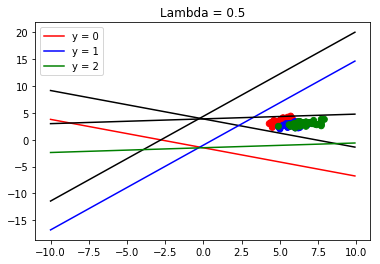

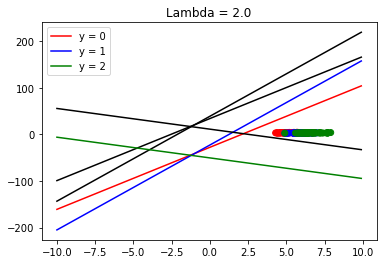

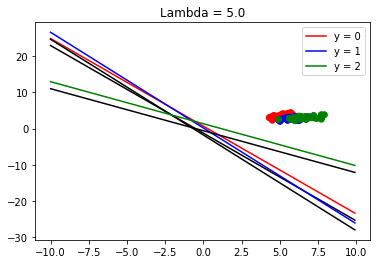

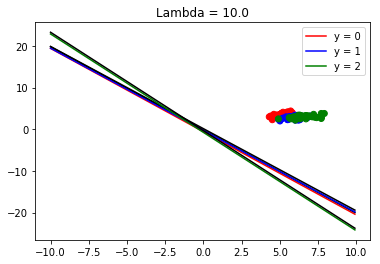

In [33]:
mcsvm = MCSVM(random_state)

for lamb in [.5, 2, 5, 10]:
    mcsvm.train(iris_train['x'], iris_train['y'], lamb = lamb, lr = .0001, iters = 500)

    W = mcsvm.W 
    plt.figure()
    plt.title("Lambda = %.1f" %(lamb))
    plotrange = np.arange(-10,10,.1)
    plt.plot(plotrange, ((1-W[0,0])-W[0,1]*plotrange)/W[1,2], color = 'r', label = 'y = 0')
    plt.plot(plotrange, ((-1-W[0,0])-W[0,1]*plotrange)/W[1,2], color = 'black')

    plt.plot(plotrange, ((1-W[1,0])-W[1,1]*plotrange)/W[1,2], color = 'b', label = 'y = 1')
    plt.plot(plotrange, ((-1-W[1,0])-W[1,1]*plotrange)/W[1,2], color = 'black')

    plt.plot(plotrange, ((1-W[2,0])-W[2,1]*plotrange)/W[1,2], color = 'g', label = 'y = 2')
    plt.plot(plotrange, ((-1-W[2,0])-W[2,1]*plotrange)/W[1,2], color = 'black')

    plt.scatter(x[:,0], x[:,1], color = np.array(['r' if yi ==0 else 'b' if yi ==1 else 'g' for yi in y]))
    plt.legend()
    print("Lambda = %f \nTrain accuracy: %f \nTest accuracy: %f\n" 
          %(
              lamb, 
              mcsvm.accuracy(iris_train['x'], iris_train['y']), 
              mcsvm.accuracy(iris_test['x'], iris_test['y'])
           )
         )
    print(W)

# Task 3: Off-the-shelf Classifiers

In [315]:
from sklearn.ensemble import RandomForestClassifier as RFC

## 3.1 One-vs-All

In [341]:
def RFC_1VA(x, y, random_state=random_state):
    n_classes = len(np.unique(y))
    classifiers = [RFC(random_state=random_state) for i in range(n_classes)]
    
    for i in range(n_classes):
        #convert to one versus all labeling
        class_i = np.unique(y)[i]
        y_1va = np.array([1 if yi == class_i else -1 for yi in y])
        classifiers[i] = classifiers[i].fit(x, y_1va)
    return(classifiers)

def predict_1VA(clfs, x):
    return(np.array(list(zip(*[clf.predict_proba(x)[:,1] for clf in clfs]))))

def predict_labels_1VA(clfs, x):
    return(np.argmax(predict_1VA(clfs, x), 1))

def accuracy_1VA(clfs, x, y):
    pred = predict_labels_1VA(clfs, x)
    return(np.sum(pred == y)/float(len(pred)))

### 3.1.1 Iris

In [342]:
clfs = RFC_1VA(iris_train['x'], iris_train['y'])

In [343]:
accuracy_1VA(clfs, iris_train['x'], iris_train['y'])

1.0

In [344]:
accuracy_1VA(clfs, iris_test['x'], iris_test['y'])

0.93333333333333335

### 3.1.2 DNA

In [320]:
clfs = RFC_1VA(dna_train['x'], dna_train['y'])

In [321]:
accuracy_1VA(clfs, dna_train['x'], dna_train['y'])

0.99857142857142855

In [322]:
accuracy_1VA(clfs, dna_test['x'], dna_test['y'])

0.93086003372681281

## 3.2 Explicit Multiclass

In [323]:
def accuracy(clf, x, y):
    pred = clf.predict(x)
    return(sum(pred == y)/float(len(pred)))

### 3.2.1 Iris

In [324]:
clf = RFC(random_state=random_state)
clf = clf.fit(iris_train['x'], iris_train['y'])

In [325]:
accuracy(clf, iris_train['x'], iris_train['y'])

1.0

In [326]:
accuracy(clf, iris_test['x'], iris_test['y'])

0.93333333333333335

### 3.1.2 DNA

In [327]:
clf = RFC(random_state=random_state)
clf = clf.fit(dna_train['x'], dna_train['y'])

In [328]:
accuracy(clf, dna_train['x'], dna_train['y'])

0.99857142857142855

In [329]:
accuracy(clf, dna_test['x'], dna_test['y'])

0.9005059021922428